# Documentation for the creation and usage of the heatpump library (hplib)




In [1]:
import hplib as hpl
import hplib_database as db
import pandas as pd
import matplotlib.pyplot as plt

## Defintions

**Abbreviation**

| Abbreviation | Meaning |
| --- | --- |
| P_th | Thermal Power in W | 

**Group IDs**
| Group ID | Type | Subtype |
| --- | --- | --- |
| 1 | Outdoor Air / Water | Inverter | 


## Database Preparation
1. we downloaded all manufacturer data from https://keymark.eu/en/products/heatpumps/certified-products
2. then we unzipped the files and used the bash-skript to convert pdf into txt
3. afterwards we used this following functions to create and extent the heatpump keymark database

In [ ]:
# Import keymark data and save to csv database
db.ImportKeymarkData()
# -> this creates /output/database_keymark.csv)

In [ ]:
# Reduce to climate measurement series with average climate, delete redundant entries and save to csv sub-database
db.ReduceKeymarkData('database_keymark.csv','average')
# -> this creates /output/database_keymark_average.csv)

In [ ]:
# Normalize electrical and thermal power from the keymark database to values from setpoint T_in = -7 °C and T_out = 52 °C
db.NormalizeKeymarkData('database_keymark_average.csv')
# -> this creates /output/database_keymark_average_normalized.csv)

In [ ]:
# Identify subtypes like On-Off, Inverter and 2-stages Heatpump and assign group depending on its type and subtype
db.IdentifySubtypes('database_keymark_average_normalized.csv')
# -> this creates /output/database_keymark_average_normalized_subtypes.csv)

In [ ]:
#Calculate parameters p1-p3 for P_th, P_el and COP
db.CalculateFunctionParameters('database_keymark_average_normalized_subtypes.csv')
# -> this creates the final hplib_database.csv

In [ ]:
#Calculate generic heatpump models for each group
db.addGeneric()
# -> this overwrites the hplib_database.csv

## Usage for simulation

In [2]:
# Have a look into the hplib database
database = hpl.loadDatabase()
database

,Manufacturer,Model,Date,Type,Subtype,Group,Refrigerant,Mass of Refrigerant [kg],SPL indoor [dBA],SPL outdoor [dBA],...,COP_ref,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p1_COP [-],p2_COP [-],p3_COP [-]
0,Advantix,i-SHWAK V4 06,2020-05-26,Outdoor Air/Water,Inverter,1.0,R410a,2.68,35.0,64.0,...,1.57,-0.023538,-0.010648,1.284505,-0.025556,0.008232,0.220768,0.141637,-0.042594,4.862194
1,Advantix,i-SHWAK V4 08,2020-05-26,Outdoor Air/Water,Inverter,1.0,R410a,2.20,35.0,64.0,...,1.72,-0.013904,-0.001533,0.923861,-0.023954,0.010072,0.169400,0.145611,-0.039244,4.806861
2,Advantix,i-SHWAK V4 10,2020-05-26,Outdoor Air/Water,Inverter,1.0,R410a,3.45,39.0,64.0,...,1.65,-0.010242,-0.007511,1.230385,-0.024239,0.009813,0.193147,0.169958,-0.073052,6.208807
3,Advantix,i-SHWAK V4 12,2020-05-26,Outdoor Air/Water,Inverter,1.0,R410a,3.45,39.0,65.0,...,2.00,-0.010428,0.001136,0.857530,-0.023218,0.011195,0.183846,0.123111,-0.077418,6.435368
4,Advantix,i-SHWAK V4 14,2020-05-26,Outdoor Air/Water,Inverter,1.0,R410a,4.40,40.0,68.0,...,1.80,-0.022154,-0.004372,0.964376,-0.028869,0.008636,0.220116,0.157131,-0.059670,5.518696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,Generic,Generic,NaN,Brine/Water,On-Off,5.0,NaN,NaN,NaN,NaN,...,2.87,-0.001788,-0.005992,1.294020,0.004298,0.015276,0.241917,-0.031898,-0.103930,8.054636
3236,Generic,Generic,NaN,Water/Water,On-Off,6.0,NaN,NaN,NaN,NaN,...,3.47,-0.001205,-0.005386,1.269886,0.001229,0.014158,0.255343,-0.011252,-0.109918,9.107949
3237,Generic,Generic,NaN,Outdoor Air/Water,2-Stages,7.0,NaN,NaN,NaN,NaN,...,1.73,-0.012521,-0.001829,1.115788,-0.019676,0.013572,0.184662,0.105186,-0.065788,5.883714
3238,Generic,Generic,NaN,Brine/Water,2-Stages,8.0,NaN,NaN,NaN,NaN,...,3.16,-0.032373,-0.002487,0.985405,-0.019649,0.012755,0.236877,-0.021645,-0.082128,7.274540


In [3]:
# Define a specific heatpump model and get parameters
parameters = hpl.getParameters('i-SHWAK V4 06')
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p1_COP [-],p2_COP [-],p3_COP [-]
0,i-SHWAK V4 06,4500.0,2866.0,1.57,1.0,-0.023538,-0.010648,1.284505,-0.025556,0.008232,0.220768,0.141637,-0.042594,4.862194


In [5]:
# Alternatively, define a "Generic" heatpump model and get parameters
# For every Group ID there is a parameter set which represents an average heatpump of its group
# Please define the Type "Generic", the Group ID (1-9) and P_th_ref in W
parameters = hpl.getParameters('Generic',1,10000)
parameters

,Model,P_th_ref [W],P_el_ref [W],COP_ref,Group,p1_P_th [1/°C],p2_P_th [1/°C],p3_P_th [-],p1_P_el [1/°C],p2_P_el [1/°C],p3_P_el [-],p1_COP [-],p2_COP [-],p3_COP [-]
0,Generic,10000,7126.222656,1.403268,1.0,-0.030129,-0.003598,0.916915,-0.030809,0.009418,0.19111,0.153743,-0.088007,7.055812


In [6]:
# Simulate on time step
# Please define T_in_primary, T_in_secondary in °C and the parameters from the previous step 
# The T_in_secondary is supposed to be heated up by 5 K
P_th, P_el, COP = hpl.simulate(-7, 47, parameters)
print('P_th: '+str(int(P_th))+' W')
print('P_el: '+str(int(P_el))+' W')
print('COP: '+str(round(COP,3)))

P_th: 8965 W
P_el: 6388 W
COP: 1.403


In [20]:
# For a time series create a loop with the function

## Overview of the efficiency range of the heatpump models within the database

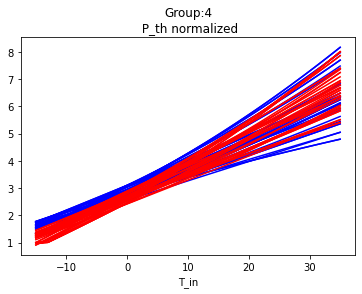

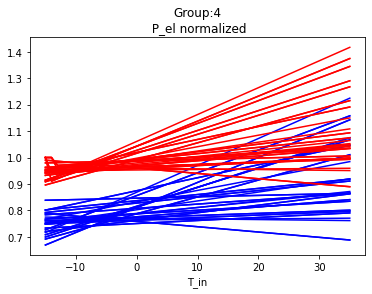

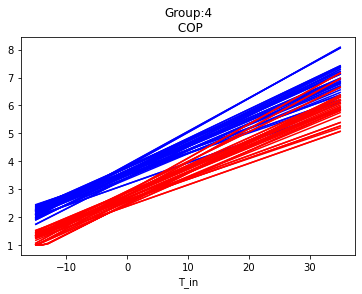

In [7]:
# Plotting the COPs for every heatpump, sorted by Group ID

para = pd.read_csv('hplib-database.csv')
#Plot Pth, Pel, COP for choosen models
Groups=[4] #define wich groups to plot
for groups_c in Groups:
    Group1=para.loc[para['Group']==groups_c,:] 
    T_in=[*range(-15,36,1)]#inflow TEMP
    T_out=[30,55]
    #get parameters
    Models=(Group1['Model'].values.tolist())
    p1_P_th=(Group1['p1_P_th [1/°C]'].values.tolist())
    p2_P_th=(Group1['p2_P_th [1/°C]'].values.tolist())
    p3_P_th=(Group1['p3_P_th [-]'].values.tolist())
    p1_P_el=(Group1['p1_P_el [1/°C]'].values.tolist())
    p2_P_el=(Group1['p2_P_el [1/°C]'].values.tolist())
    p3_P_el=(Group1['p3_P_el [-]'].values.tolist())
    p1_COP=(Group1['p1_COP [-]'].values.tolist())
    p2_COP=(Group1['p2_COP [-]'].values.tolist())
    p3_COP=(Group1['p3_COP [-]'].values.tolist())
    p_el_ref=Group1['P_el_ref [W]'].values.tolist()
    p_th_ref=Group1['P_th_ref [W]'].values.tolist()
    i=0 #iterator for-loop
    #create Dataframes to plot
    COP_low_g=pd.DataFrame()
    COP_low_g['T_in']=T_in
    COP_high_g=pd.DataFrame()
    COP_high_g['T_in']=T_in
    Average_g=pd.DataFrame()
    Average_g['T_in']=T_in
    #get average values
    k7_average=Group1[-1:]['p1_COP [-]'].values.tolist()[0]
    k8_average=Group1[-1:]['p2_COP [-]'].values.tolist()[0]
    k9_average=Group1[-1:]['p3_COP [-]'].values.tolist()[0]
   
    for number in p1_P_th: #iterate by all models
        P_th_low=[]
        P_th_high=[]
        P_el_low=[]
        P_el_high=[]
        COP_low=[]
        COP_high=[]
        Average_pth_low=[]
        Average_pel_low=[]
        Average_cop_low=[]
        Average_pth_high=[]
        Average_pel_high=[]
        Average_cop_high=[]
        for tin in T_in: #calculate Thermal and electric Power and COP
            p_th_low,p_el_low,cop_low=hpl.simulate(tin,T_out[0],Group1.iloc[i:i+1])
            p_th_high,p_el_high,cop_high=hpl.simulate(tin,T_out[1],Group1.iloc[i:i+1])
            P_th_low.append(p_th_low)
            P_th_high.append(p_th_high)
            P_el_low.append(p_el_low)
            P_el_high.append(p_el_high)
            COP_low.append(cop_low)
            COP_high.append(cop_high)
            """#calculate for average values
            Average_pth_low.append(average_pthlow)
            Average_pth_high.append(average_pthhigh)
            Average_pel_low.append(average_pellow)
            Average_pel_high.append(average_pelhigh)
            average_low= k7_average * tin + k8_average * T_out[0] + k9_average
            average_high= k7_average * tin + k8_average * T_out[1] + k9_average
            Average_cop_low.append(average_low)
            Average_cop_high.append(average_high)
        """
        #write values in a dataframe
        P_th_low_g[Models[i]]=P_th_low
        P_th_high_g[Models[i]]=P_th_high
        P_el_low_g[Models[i]]=P_el_low
        P_el_high_g[Models[i]]=P_el_high
        COP_low_g[Models[i]]=COP_low
        COP_high_g[Models[i]]=COP_high
        #Average_g['P_th_low']=Average_pth_low
        #Average_g['P_el_low']=Average_pel_low
        #Average_g['COP_low']=Average_cop_low
        #Average_g['P_th_high']=Average_pth_high
        #Average_g['P_el_high']=Average_pel_high
        #Average_g['COP_high']=Average_cop_high
        i=i+1 #increase iterator


    #Plot: thermal power
    fig, axes = plt.subplots(nrows=1, ncols=1)
    variable=str(groups_c)
    P_th_low_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Blue', title='Group:' + variable + '\n P_th normalized', legend=False)
    P_th_high_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Red', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='P_th_low', kind='line', c='Black', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='P_th_high', kind='line', c='Black', legend=False)
    plt.show()

    #Plot: electric Power
    fig, axes = plt.subplots(nrows=1, ncols=1)
    
    P_el_low_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Blue', title='Group:' + variable + '\n P_el normalized', legend=False)
    P_el_high_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Red', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='P_el_low', kind='line', c='Black', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='P_el_high', kind='line', c='Black', legend=False)
    plt.show()

    #Plot:COP
    fig, axes = plt.subplots(nrows=1, ncols=1)

    COP_low_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Blue', title='Group:' + variable + '\n COP', legend=False)
    COP_high_g.plot(ax=axes, x='T_in', y=Models, kind='line', c='Red', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='COP_low', kind='line', c='Black', legend=False)
    #Average_g.plot(ax=axes, x='T_in', y='COP_high', kind='line', c='Black', legend=False)
    plt.show()
